In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn

In [3]:
weather_data = pd.read_csv("Data/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_data.head()

,Month,Day,Hour,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_TEMP_QCL3
0,1,1,0,0.000003,0.00036,-18.197324,0.389565,13.100358
1,1,1,1,0.000007,0.00000,-16.227891,0.222602,12.669197
2,1,1,2,0.000009,0.00000,-13.710884,0.217194,12.520271
3,1,1,3,0.000000,0.00000,-16.401361,0.178248,12.386194
4,1,1,4,0.000000,0.00000,-10.268707,0.237670,12.080706


In [4]:
temp_series = pd.Series(weather_data['LC_TEMP_QCL3'])
rain_series = pd.Series(weather_data['LC_DAILYRAIN'])

Temperature

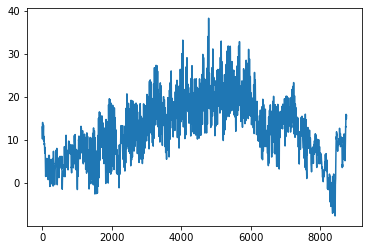

In [63]:
plt.plot(temp_series)
plt.show()

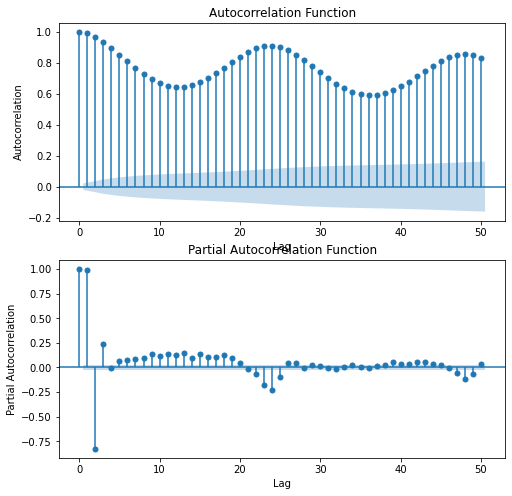

In [69]:
lags = 50  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(temp_series, ax=ax1, lags=lags)
ax1.set(title='Autocorrelation Function', xlabel='Lag', ylabel='Autocorrelation')

plot_pacf(temp_series, ax=ax2, lags=lags)
ax2.set(title='Partial Autocorrelation Function', xlabel='Lag', ylabel='Partial Autocorrelation')
plt.show()

In [65]:
result = adfuller(temp_series)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
#Stationary, but ADF test is not sensitive to seasonality, only unit root.

ADF Statistic: -4.02969234763754
p-value: 0.0012627701282143253


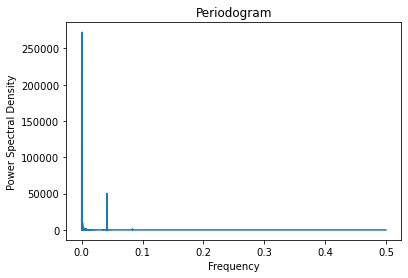

In [100]:
freq, power = scipy.signal.periodogram(temp_series)
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')
plt.show()
#Spike at 1/24, also spike near 0 => long memory process?

Differenced + seasonally differenced temperature

<function matplotlib.pyplot.show(close=None, block=None)>

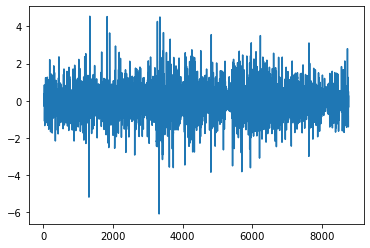

In [76]:
dtemp_series = temp_series.diff(24).diff().dropna()
plt.plot(dtemp_series)
plt.show

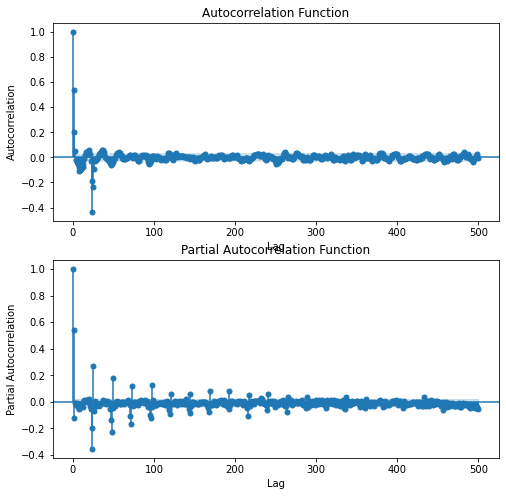

In [106]:
lags = 500
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(dtemp_series, ax=ax1, lags=lags)
ax1.set(title='Autocorrelation Function', xlabel='Lag', ylabel='Autocorrelation')

plot_pacf(dtemp_series, ax=ax2, lags=lags)
ax2.set(title='Partial Autocorrelation Function', xlabel='Lag', ylabel='Partial Autocorrelation')
plt.show()

In [78]:
result = adfuller(dtemp_series)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
#Stationary

ADF Statistic: -23.556372860598188
p-value: 0.0


In [90]:
temp_model = auto_arima(temp_series, start_p = 0, d = 0, start_q = 5, max_p = 10, max_d = 5, max_q = 10, seasonal = True)

In [91]:
temp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(3, 0, 9)   Log Likelihood               -6017.028
Date:                Sun, 21 May 2023   AIC                          12060.057
Time:                        15:45:22   BIC                          12152.070
Sample:                             0   HQIC                         12091.409
                               - 8760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.9280      0.001   4080.313      0.000       2.927       2.929
ar.L2         -2.9242      0.001  -2080.021      0.000      -2.927      -2.921
ar.L3          0.9961      0.001   1405.820      0.000       0.995       0.997
ma.L1         -1.1870      0.006   -185.377      0.000      -1.200      -1.174
ma.L2         -0.1162      0.010    -11.121      0.000      -0.137      -0.096
ma.L3          0.1542      0.011     13.473      0.000       0.132       0.177
ma.L4          0.1302      0.014      9.333      0.000       0.103       0.158
ma.L5          0.0846      0.014      5.893      0.000       0.056       0.113
ma.L6          0.0568      0.014      3.943      0.000       0.029       0.085
ma.L7          0.0613      0.016      3.926      0.000       0.031       0.092
ma.L8         -0.0143      0.015     -0.981      0.327      -0.043       0.014
ma.L9         -0.0887      0.010     -9.005      0.000      -0.108      -0.069
sigma2         0.2309      0.002    121.363      0.000       0.227       0.235
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):             21102.31
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.24
Prob(H) (two-sided):                  0.81   Kurtosis:                        10.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
order = (1, 0, 1)              
seasonal_order = (10, 0, 0, 24)
temp_model = sm.tsa.statespace.SARIMAX(dtemp_series, order=order, seasonal_order=seasonal_order)
result = temp_model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


KeyboardInterrupt: 

Rain

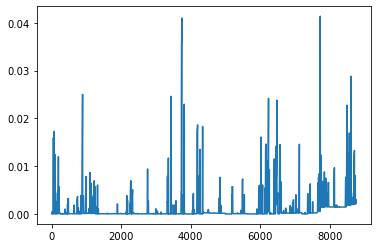

In [80]:
plt.plot(rain_series)
plt.show()

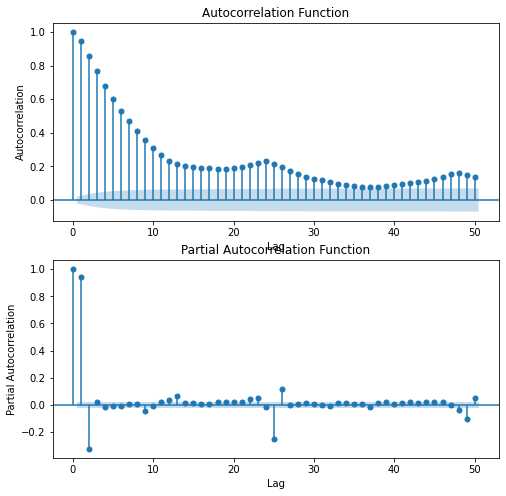

In [103]:
lags = 50 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(rain_series, ax=ax1, lags=lags)
ax1.set(title='Autocorrelation Function', xlabel='Lag', ylabel='Autocorrelation')

plot_pacf(rain_series, ax=ax2, lags=lags)
ax2.set(title='Partial Autocorrelation Function', xlabel='Lag', ylabel='Partial Autocorrelation')
plt.show()

In [82]:
result = adfuller(rain_series)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
#Stationary

ADF Statistic: -12.88972662138564
p-value: 4.4751581966352826e-24


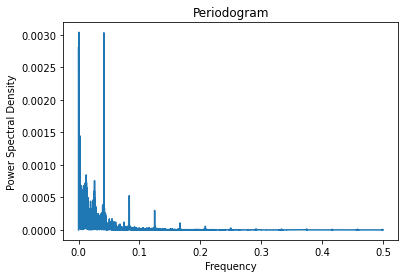

In [101]:
freq, power = scipy.signal.periodogram(rain_series)
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')
plt.show()
#Much bigger spike at 1/24 with overtones

Differenced + seasonally differenced rain

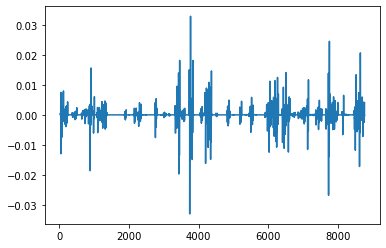

In [94]:
drain_series = rain_series.diff(24).diff().dropna()
plt.plot(drain_series)
plt.show()

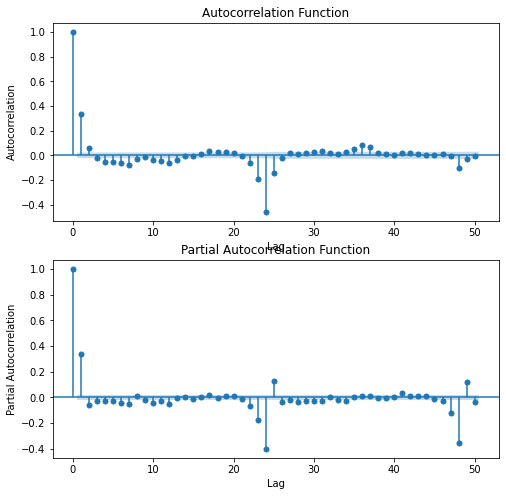

In [95]:
lags = 50  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(drain_series, ax=ax1, lags=lags)
ax1.set(title='Autocorrelation Function', xlabel='Lag', ylabel='Autocorrelation')

plot_pacf(drain_series, ax=ax2, lags=lags)
ax2.set(title='Partial Autocorrelation Function', xlabel='Lag', ylabel='Partial Autocorrelation')
plt.show()